In [1]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

T = 200
IMG_SIZE = 28
BATCH_SIZE = 128
EPOCHS = 20
LR = 2e-4
NUM_CLASSES = 10
TIME_EMB_DIM = 32
LABEL_EMB_DIM = 32

os.makedirs("training_logs", exist_ok=True)
os.makedirs("training_logs/samples_during_training", exist_ok=True)

Using device: cuda


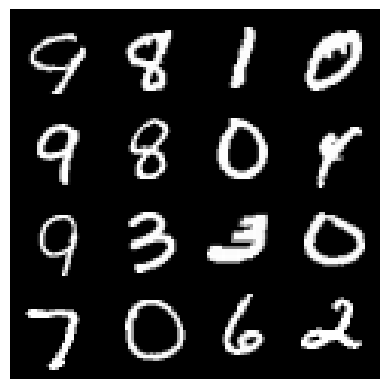

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.ToTensor(),             
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

images, labels = next(iter(train_loader))
grid = make_grid(images[:16], nrow=4, normalize=True)
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()

In [3]:
def make_beta_schedule(timesteps: int, start=1e-4, end=0.02):
    return torch.linspace(start, end, timesteps)

betas = make_beta_schedule(T).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat(
    [torch.tensor([1.0], device=device), alphas_cumprod[:-1]], dim=0
)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ac = sqrt_alphas_cumprod[t].view(-1,1,1,1)
    sqrt_om = sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
    return sqrt_ac * x0 + sqrt_om * noise


In [4]:
import math


def sinusoidal_time_embedding(timesteps, dim):
    half = dim // 2
    factor = math.log(10000) / (half - 1)
    exps = torch.exp(torch.arange(half, device=timesteps.device) * -factor)
    angles = timesteps.float().unsqueeze(1) * exps.unsqueeze(0)
    return torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)

In [5]:
import torch.nn as nn


class SmallUNet(nn.Module):
    def __init__(self, num_classes=10, time_dim=32, label_dim=32):
        super().__init__()

        self.time_dim = time_dim
        self.label_dim = label_dim
        self.num_classes = num_classes

        self.label_emb = nn.Embedding(num_classes, label_dim)

        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, 64), nn.ReLU(),
            nn.Linear(64, 64)
        )

        self.label_mlp = nn.Sequential(
            nn.Linear(label_dim, 64), nn.ReLU(),
            nn.Linear(64, 64)
        )

        in_channels = 1 + 64 + 64

        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU()
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.ReLU()
        )

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.GroupNorm(8, 256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.GroupNorm(8, 256),
            nn.ReLU()
        )

        self.up = nn.Upsample(scale_factor=2, mode="nearest")

        self.up1 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU()
        )

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x, t, y):
        B, _, H, W = x.shape

        t_emb = sinusoidal_time_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)

        y_clamped = torch.clamp(y, 0, self.num_classes - 1)
        y_emb = self.label_emb(y_clamped)
        y_emb = self.label_mlp(y_emb)

        y_mask = (y == -1).float().view(B, 1)
        y_emb = y_emb * (1 - y_mask)

        t_map = t_emb.view(B, 64, 1, 1).expand(-1, -1, H, W)
        y_map = y_emb.view(B, 64, 1, 1).expand(-1, -1, H, W)

        x = torch.cat([x, t_map, y_map], dim=1)

        d1 = self.down1(x)
        d2 = self.down2(self.pool(d1))

        b = self.bottleneck(self.pool(d2))

        u1 = self.up(b)
        u1 = torch.cat([u1, d2], dim=1)
        u1 = self.up1(u1)      

        u2 = self.up(u1)                     
        u2 = torch.cat([u2, d1], dim=1)
        u2 = self.up2(u2)                    

        return self.out(u2)              

In [6]:
import torch.nn.functional as F


def cosine_similarity(a, b):
    return F.cosine_similarity(
        a.flatten(start_dim=1),
        b.flatten(start_dim=1)
    ).mean().item()

def psnr(x1, x2):
    mse = F.mse_loss(x1, x2)
    if mse == 0:
        return 50.0
    return 10 * torch.log10(1.0 / mse).item()

In [7]:
model = SmallUNet(
    num_classes=NUM_CLASSES,
    time_dim=TIME_EMB_DIM,
    label_dim=LABEL_EMB_DIM
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

metrics = {
    "epoch_loss": [],
    "noise_cosine": [],
    "psnr": [],
    "epoch_time_sec": []
}

In [8]:
def get_random_timesteps(batch_size):
    return torch.randint(0, T, (batch_size,), device=device)

def train_step(model, optimizer, images, labels):
    model.train()
    images = images.to(device)
    labels = labels.to(device)

    batch_size = images.size(0)
    t = get_random_timesteps(batch_size)

    noise = torch.randn_like(images)
    x_noisy = q_sample(images, t, noise)

    pred_noise = model(x_noisy, t, labels)

    loss = criterion(pred_noise, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    cos_sim = cosine_similarity(pred_noise.detach(), noise)

    x0_estimate = (x_noisy - noise * sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)) \
                  / sqrt_alphas_cumprod[t].view(-1,1,1,1)
    x0_estimate = x0_estimate.clamp(-1, 1)

    psnr_value = psnr(x0_estimate, images)

    return loss.item(), cos_sim, psnr_value

In [9]:
@torch.no_grad()
def p_sample(model, x, t, y, guidance_scale=7.5):
    B = x.size(0)
    t_batch = torch.full((B,), t, device=device, dtype=torch.long)

    eps_cond = model(x, t_batch, y)

    y_uncond = torch.full_like(y, -1)
    eps_uncond = model(x, t_batch, y_uncond)

    eps_theta = eps_uncond + guidance_scale * (eps_cond - eps_uncond)

    beta_t = betas[t]
    sqrt_one_minus_ac_t = sqrt_one_minus_alphas_cumprod[t]
    sqrt_recip_alpha_t = sqrt_recip_alphas[t]

    mean = sqrt_recip_alpha_t * (x - beta_t / sqrt_one_minus_ac_t * eps_theta)

    if t > 0:
        noise = torch.randn_like(x)
        sample = mean + torch.sqrt(beta_t) * noise
    else:
        sample = mean

    return sample

@torch.no_grad()
def p_sample_loop(model, y, img_size=28, guidance_scale=7.5):
    model.eval()
    B = y.size(0)
    x = torch.randn(B, 1, img_size, img_size, device=device)

    for t in reversed(range(T)):
        x = p_sample(model, x, t, y, guidance_scale=guidance_scale)

    return x

In [10]:
import json
import time
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    epoch_loss = 0.0
    epoch_cosine = 0.0
    epoch_psnr = 0.0
    num_batches = 0

    for batch_images, batch_labels in train_loader:
        loss, cos_val, psnr_val = train_step(model, optimizer, batch_images, batch_labels)

        epoch_loss += loss
        epoch_cosine += cos_val
        epoch_psnr += psnr_val
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    avg_cos = epoch_cosine / num_batches
    avg_psnr = epoch_psnr / num_batches
    epoch_time = time.time() - start_time

    metrics["epoch_loss"].append(avg_loss)
    metrics["noise_cosine"].append(avg_cos)
    metrics["psnr"].append(avg_psnr)
    metrics["epoch_time_sec"].append(epoch_time)

    with open("training_logs/metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Cosine Noise: {avg_cos:.4f}")
    print(f"  PSNR: {avg_psnr:.2f}")
    print(f"  Time: {epoch_time:.2f}s")

    torch.save(model.state_dict(), f"training_logs/checkpoint_epoch_{epoch}.pth")

    if epoch % 2 == 0:
        ys = torch.tensor([0,1,2,3,4,5,6,7,8,9], device=device)
        samples = p_sample_loop(model, ys)
        samples = (samples.clamp(-1,1) + 1) / 2

        grid = make_grid(samples, nrow=10)
        plt.figure(figsize=(12,2))
        plt.imshow(grid.permute(1,2,0).cpu().numpy())
        plt.axis("off")
        plt.savefig(f"training_logs/samples_during_training/epoch_{epoch}.png")
        plt.close()

Epoch 1/20
  Loss: 0.1253
  Cosine Noise: 0.9311
  PSNR: 149.51
  Time: 48.47s
Epoch 2/20
  Loss: 0.0657
  Cosine Noise: 0.9665
  PSNR: 149.52
  Time: 49.35s
Epoch 3/20
  Loss: 0.0585
  Cosine Noise: 0.9702
  PSNR: 149.52
  Time: 50.16s
Epoch 4/20
  Loss: 0.0556
  Cosine Noise: 0.9718
  PSNR: 149.51
  Time: 50.81s
Epoch 5/20
  Loss: 0.0540
  Cosine Noise: 0.9726
  PSNR: 149.55
  Time: 50.45s
Epoch 6/20
  Loss: 0.0524
  Cosine Noise: 0.9734
  PSNR: 149.51
  Time: 50.34s
Epoch 7/20
  Loss: 0.0511
  Cosine Noise: 0.9741
  PSNR: 149.53
  Time: 50.21s
Epoch 8/20
  Loss: 0.0502
  Cosine Noise: 0.9745
  PSNR: 149.52
  Time: 49.98s
Epoch 9/20
  Loss: 0.0498
  Cosine Noise: 0.9747
  PSNR: 149.50
  Time: 50.41s
Epoch 10/20
  Loss: 0.0488
  Cosine Noise: 0.9752
  PSNR: 149.50
  Time: 50.11s
Epoch 11/20
  Loss: 0.0486
  Cosine Noise: 0.9753
  PSNR: 149.52
  Time: 50.32s
Epoch 12/20
  Loss: 0.0482
  Cosine Noise: 0.9755
  PSNR: 149.51
  Time: 50.32s
Epoch 13/20
  Loss: 0.0477
  Cosine Noise: 0.9758

In [11]:
torch.save(model.state_dict(), "model.pth")
print("Final model saved as model.pth")

Final model saved as model.pth


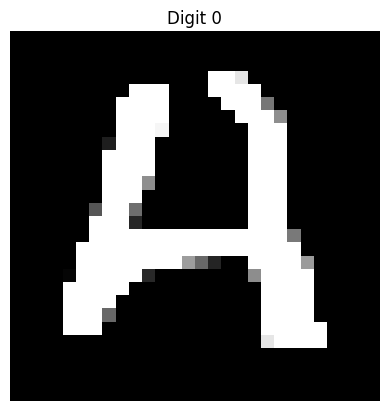

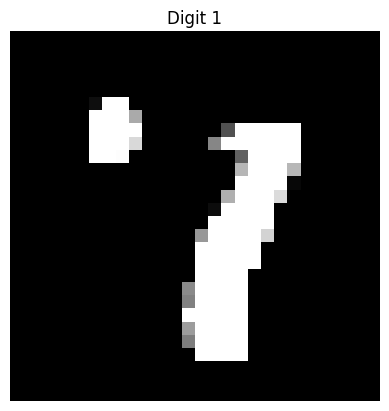

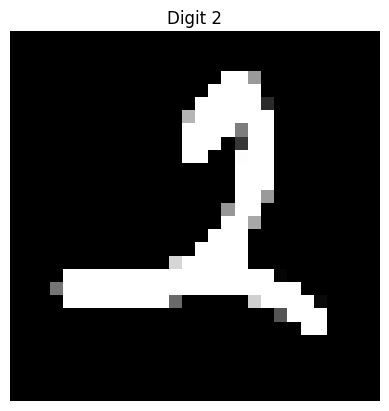

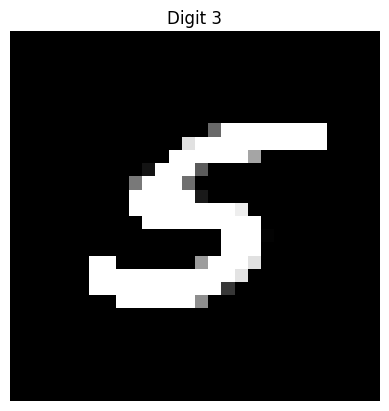

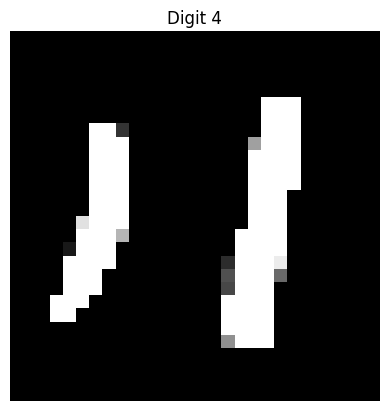

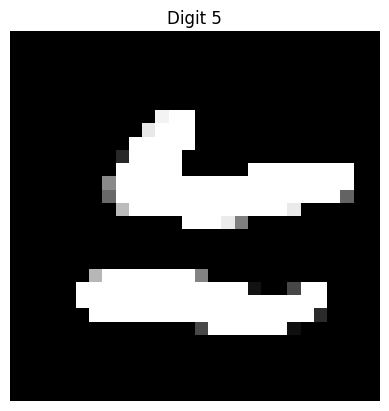

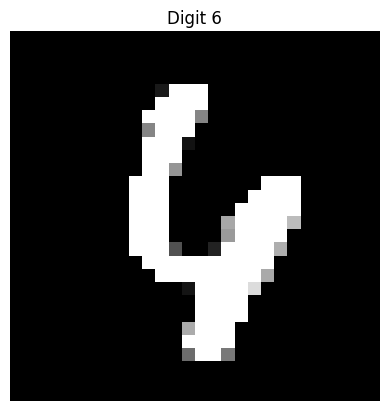

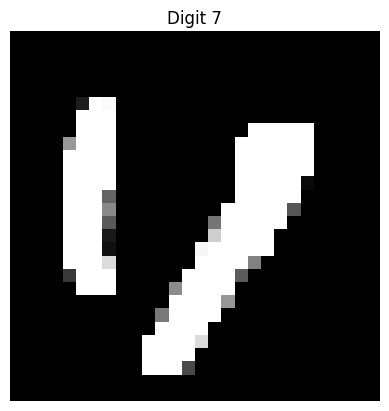

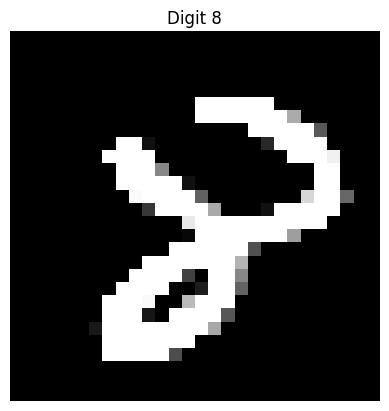

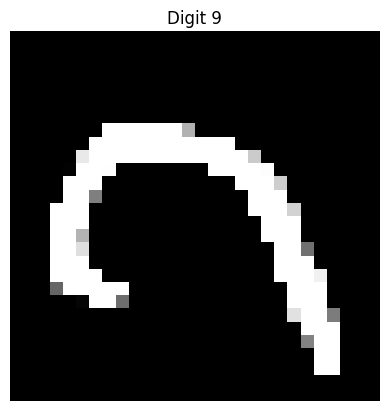

In [12]:
model.eval()
with torch.no_grad():
    ys = torch.tensor([0,1,2,3,4,5,6,7,8,9], device=device)
    samples = p_sample_loop(model, ys)
    samples = (samples.clamp(-1,1) + 1) / 2

for i in range(10):
    plt.figure()
    plt.title(f"Digit {i}")
    plt.imshow(samples[i,0].cpu().numpy(), cmap="gray")
    plt.axis("off")
    plt.show()